In [115]:
import os
import torch
import time
import cv2
import PIL
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim

from PIL                     import Image
from torch.utils.data        import Dataset, DataLoader
from torchvision             import transforms, datasets
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d    import Axes3D
from sklearn.preprocessing   import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from skimage.feature import hog
from skimage.io import imread


# Ignore all warnings
warnings.filterwarnings("ignore")

In [40]:
# Plot per column distribution (function)
def plot_col_distribution(df):
    for col in df.columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

# Plot correlation matrix (function)
def plot_corr_matrix(df):
    c_matrix = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(c_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

In [41]:
class DataLoad(Dataset):
    
    # Ref from https://stackoverflow.com
    
    def __init__(self, root_dir, transform=None):
        self.root_dir     = root_dir
        self.transform    = transform
        self.classes      = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images       = self.load_images()
        
        
    def __len__(self):
        return len(self.images)
    
    def load_images(self):
        images = []
        for class_dir in self.classes:
            class_path = os.path.join(self.root_dir, class_dir)
            
            # Ignore if it is not a directory
            if not os.path.isdir(class_path):
                continue  
            for image_name in os.listdir(class_path):
                
                # Skip if .DS_Store files
                if image_name.startswith('.DS_Store'):
                    continue  
                image_path = os.path.join(class_path, image_name)
                images.append((image_path, self.class_to_idx[class_dir]))
        return images


    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [130]:
def train_model(model, train_loader, num_epochs=5):
    # Define Cross Entropy as the Loss function
    criterion = nn.CrossEntropyLoss()
    # Define Adam as the optimiser with 0.001 learning rate
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loss = []  # create a list to store train loss at each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        for img, lbl in train_loader:
            img, lbl = img.to(device), lbl.to(device)
            optimizer.zero_grad() # zero out the accumulated gradients
            outputs = model(img)
            loss = criterion(outputs, lbl)
            loss.backward() # Apply the loss function
            optimizer.step() # update the parameters with current gradients
            running_loss += loss.item()

        # Calculate the average training loss for the running epoch and append to the training loss list
        avg_train_loss = running_loss / len(train_loader)
        train_loss.append(avg_train_loss)

        # Print the training loss for each epoch and store it
        print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_train_loss:.4f}')
    return model, train_loss

In [43]:
# Function for displaying a sample 5*5 grid images along with predicted and true labels
def disp_images(img, pred_labels, true_labels):
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(img[i].permute(1, 2, 0))  # Convert from (Channel, Height, Width) to (Height, Width, Channel)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Predicted label: {pred_labels[i]}\nTrue label: {true_labels[i]}')
    plt.tight_layout()
    plt.show()

In [44]:
def evaluate_model(model, test_loader, num_epochs=5):
    # Define Cross Entropy as the Loss function
    criterion = nn.CrossEntropyLoss()

    test_loss = []
    accuracy = []
    # Evaluate the trained model
    for epoch in range(num_epochs):
        images = []
        true_labels = []
        pred_labels = []
        model.eval()

        # Ref from https://stackoverflow.com
        with torch.no_grad():
            total = 0
            running_loss = 0.0
            correct = 0
            for img_batch, lbl_batch in test_loader:
                img_batch, lbl_batch = img_batch.to(device), lbl_batch.to(device)
                output = model(img_batch)
                loss = criterion(output, lbl_batch)
                running_loss += loss.item()

                _, pred_batch = torch.max(output.data, 1)

                pred_labels.extend(pred_batch.tolist())
                true_labels.extend(lbl_batch.tolist())
                images.extend(img_batch)

                total += lbl_batch.size(0)
                correct += (pred_batch == lbl_batch).sum().item()

            # Calculate average test loss and accuracy and then append to the respective lists
            avg_loss = running_loss / len(test_loader)
            test_loss.append(avg_loss)

            acc = correct / total
            accuracy.append(acc)

            # Print the accuracy and test loss for each epoch. (Accuracy * 100) to display the percentage
            print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {100 * acc:.2f}%')
            
    return pred_labels, true_labels, test_loss, accuracy, images

In [45]:
def plot_confusion_matrix(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(13, 10))
    sns.heatmap(cm, fmt='d', cmap='Blues', annot=True, cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [46]:
def plot_loss_graphs(train_loss, test_loss, accuracy):
    plt.figure(figsize=(13, 5))

    plt.subplot(1, 2, 1)
    plt.title('Train & Test Losses')
    plt.plot(train_loss, label='Train')
    plt.plot(test_loss, label='Test')
    plt.xlabel('Epoch number')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.title('Test Accuracy')
    plt.plot(accuracy, color='skyblue')
    plt.xlabel('Epoch number')
    plt.ylabel('Accuracy')
    plt.show()

## Load data

In [48]:
# Load the file - Meta.csv; check for rows and columns
meta_df = pd.read_csv('Data/Meta.csv')
meta_df.dataframeName = 'Meta.csv'
nRow, nCol = meta_df.shape
print(f'Meta Data - {nRow} rows and {nCol} columns')
meta_df.head(5)

Meta Data - 43 rows and 5 columns


,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [49]:
# Load the file - Train.csv; check for rows and columns
train_df = pd.read_csv('Data/Train.csv')
train_df.dataframeName = 'Train.csv'
nRow, nCol = train_df.shape
print(f'Train Data - {nRow} rows and {nCol} columns')
train_df.head(5)

Train Data - 39209 rows and 8 columns


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [117]:
# Load the file - Test.csv; check for rows and columns
test_df = pd.read_csv('Data/Test.csv')
test_df.dataframeName = 'Test.csv'
nRow, nCol = test_df.shape
print(f'Test Data - {nRow} rows and {nCol} columns')
test_df.head(5)

Test Data - 12630 rows and 8 columns


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


## EDA

In [93]:
# Pick 1000 rows as samples from the datasets for EDA purpose as the full dataset would be huge to analyse
s_train = train_df.sample(n=1000, random_state=42) 
s_test = test_df.sample(n=1000, random_state=42)

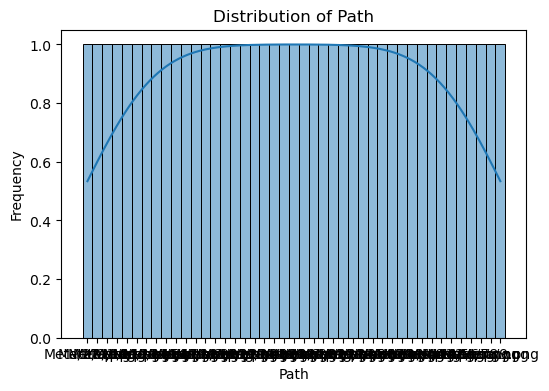

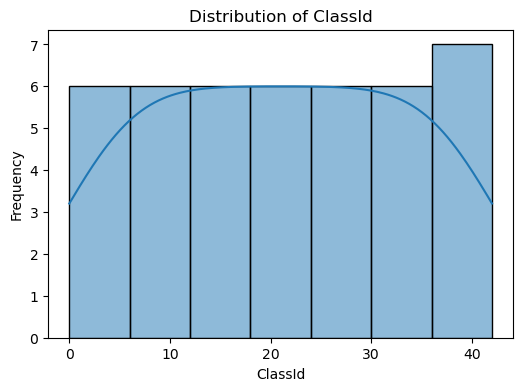

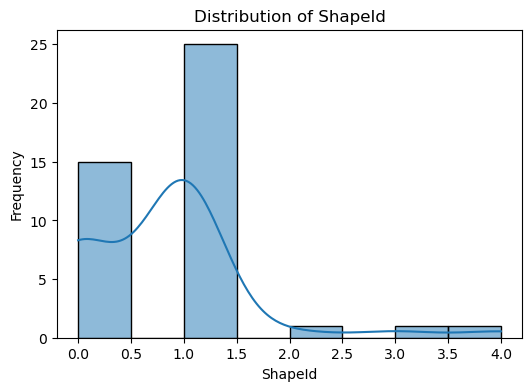

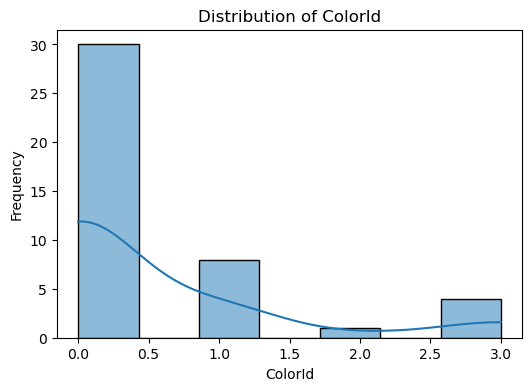

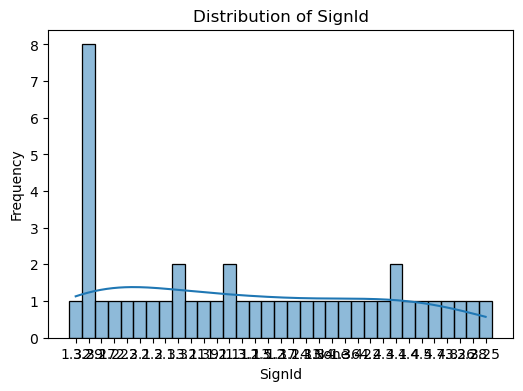

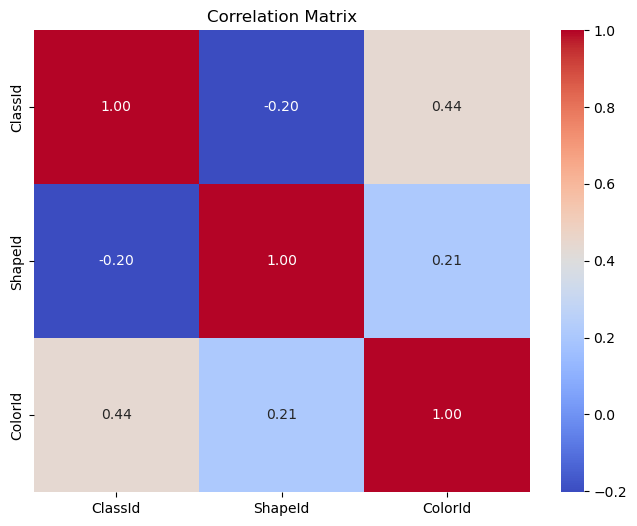

In [52]:
# EDA for Meta data
plot_col_distribution(meta_df)
plot_corr_matrix(meta_df)

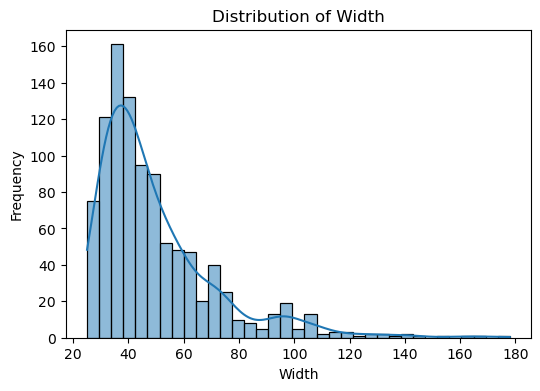

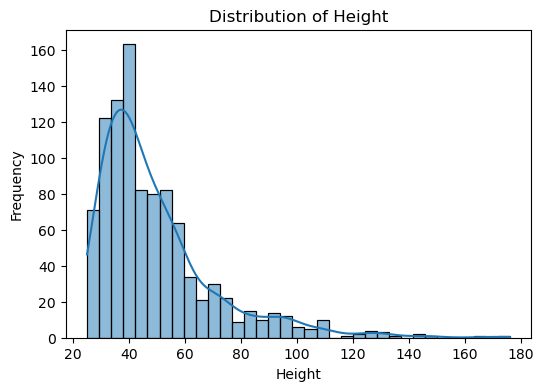

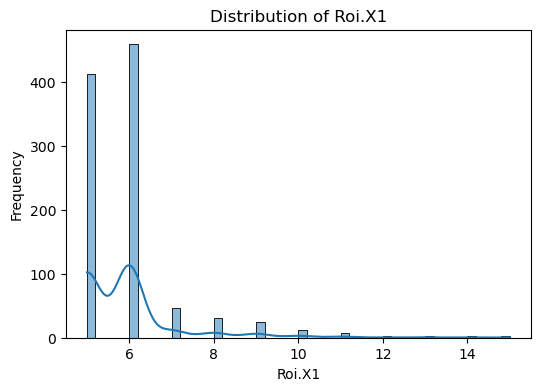

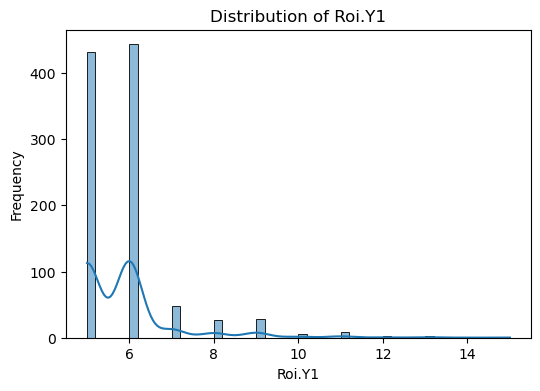

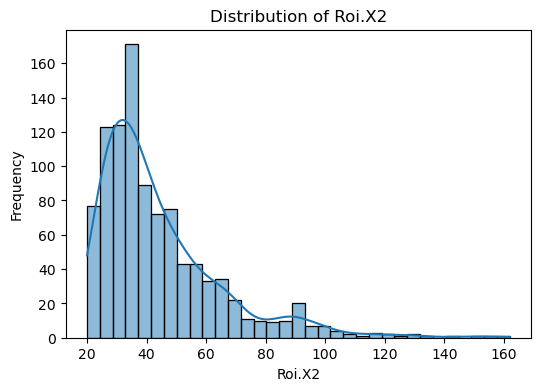

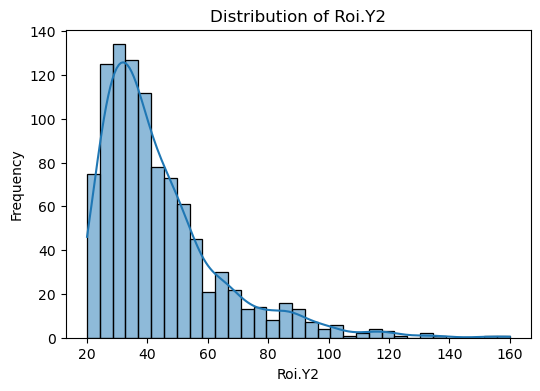

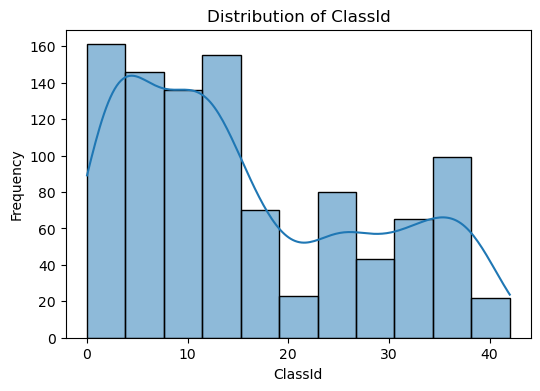

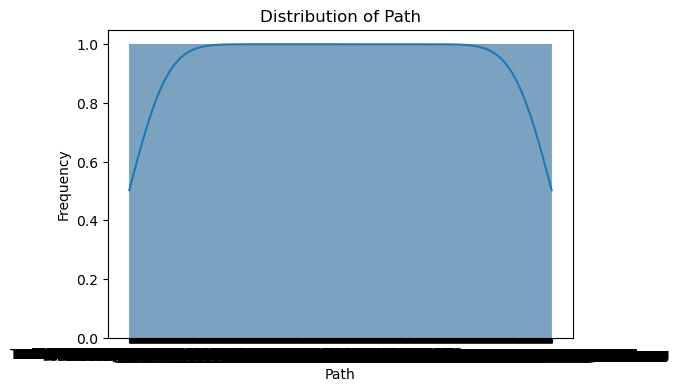

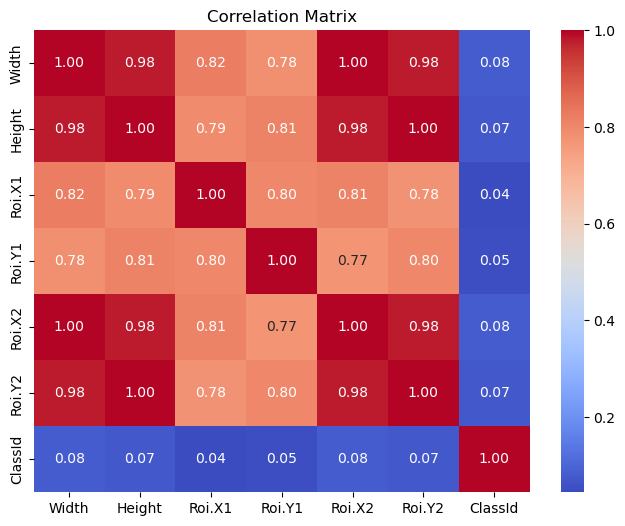

In [53]:
# EDA for Sample Train data
plot_col_distribution(s_train)
plot_corr_matrix(s_train)

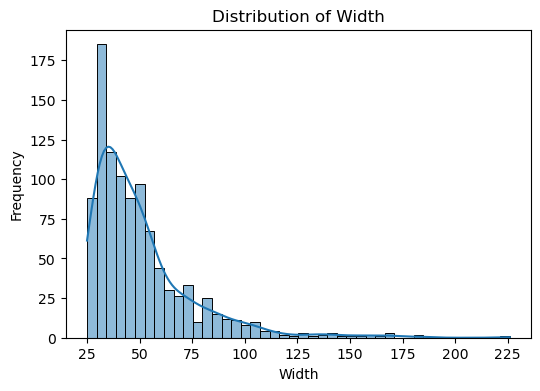

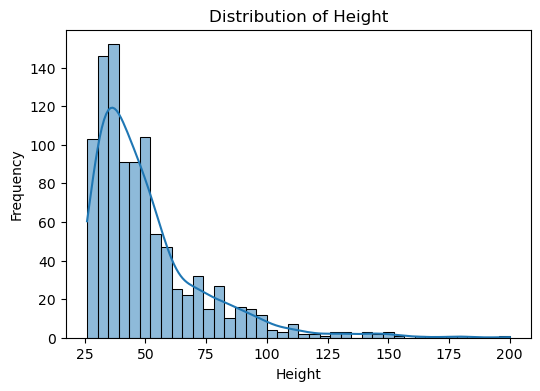

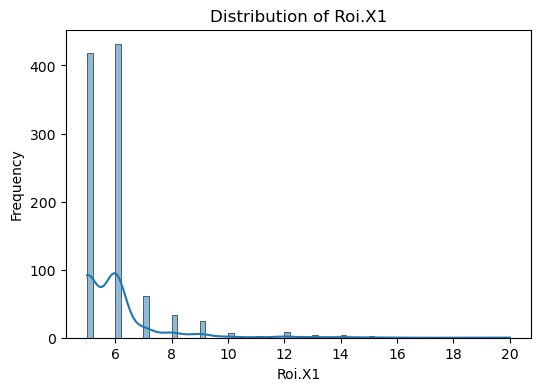

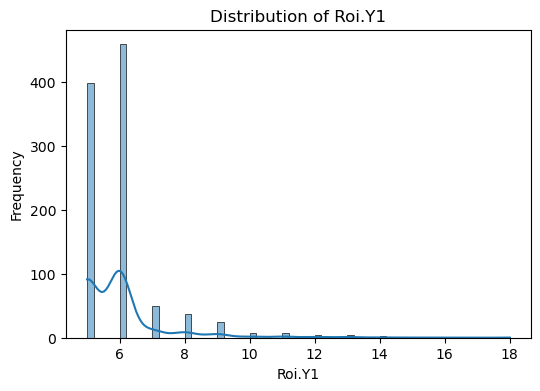

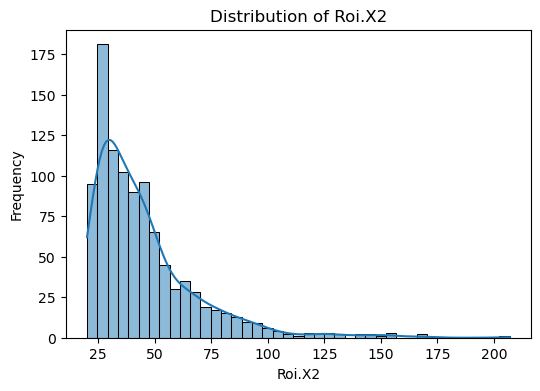

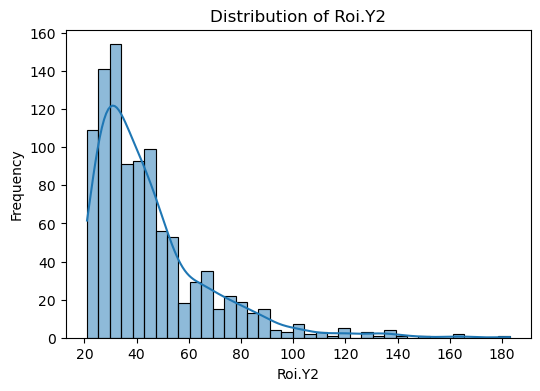

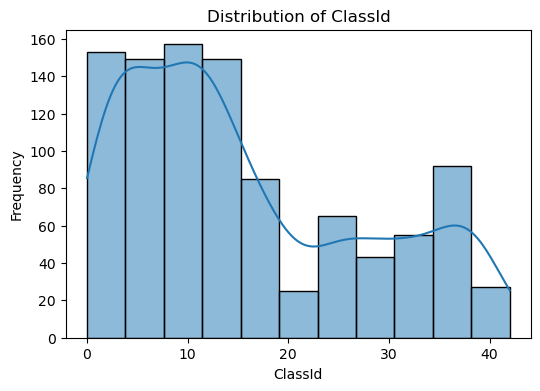

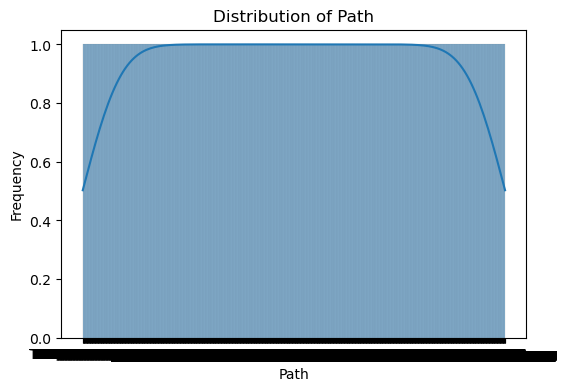

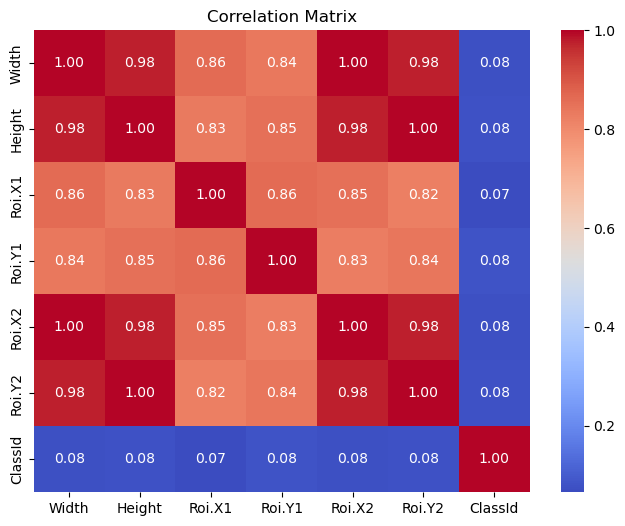

In [129]:
# EDA for Sample Test data
plot_col_distribution(s_test)
plot_corr_matrix(s_test)

Text(0, 0.5, 'Image Count')

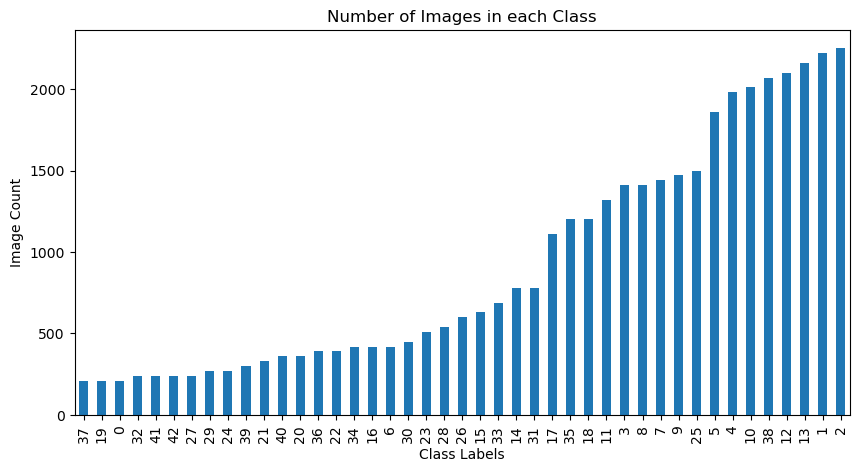

In [180]:
# Following code is to count no. of images in each class

image_count = {} # A dictionary to store the no. of images

# Go through each folder to count the number of images in each class
for class_folder in os.listdir(cur_path + '/Data/Train'):
    # Skip if .DS_Store files
    if class_folder.startswith('.DS_Store'):
        continue
    # Count the images in current folder
    image_count[class_folder] = len(os.listdir(cur_path + '/Data/Train/' + class_folder))

# Save all image counts with respect to the class label
image_data = pd.Series(image_count)

# Visualise the image count in each class label through a bar plot
plt.figure(figsize=(10, 5))
image_data.sort_values().plot(kind='bar')  # Sort as per image counts
plt.title('Number of Images in each Class')
plt.xlabel('Class Labels')
plt.ylabel('Image Count')

## Train-Test Loader

In [177]:
# Define transformations for Data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224,224))   
])

# Load the dataset with the applied transformations
dataset = DataLoad(root_dir="Data/Train",transform=transform)

In [178]:
# Print the total number of images and total number of classes
print(f"Total Classes: {len(dataset.classes)}")
print(f"Total Images: {dataset.__len__()}")

train_data_size = int(0.8 * len(dataset))
test_data_size  = len(dataset) - train_data_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_data_size, test_data_size])
print(f"")
print(f"Train Images: {train_data.__len__()} ; Test Images: {test_data.__len__()}")

# Load the data in batches and print to see the distribution
train_loader = DataLoader(train_data, shuffle=True, batch_size=32)
test_loader  = DataLoader(test_data, shuffle=True, batch_size=32)
print(f"")
print(f"Train Batches: {len(train_loader)}")
print(f"Test Batches: {len(test_loader)}")


Total Classes: 44
Total Images: 39209

Train Images: 31367 ; Test Images: 7842

Train Batches: 981
Test Batches: 246


## CNN Model

In [131]:
# Define the model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128,num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [133]:
cnn_model = CNN(len(dataset.classes)).to(device)

In [134]:
start_cnn = time.time()
cnn_model, train_loss = train_model(cnn_model, train_loader, 5)
end_cnn = time.time()

# Calculate time taken by CNN to train
time_cnn = end_cnn - start_cnn
print("CNN Training time:", time_cnn, "seconds")

# Save the trained cnn model
torch.save(cnn_model.state_dict(), 'cnn_model.pth')

Epoch 1/5 - Training Loss: 1.3227
Epoch 2/5 - Training Loss: 0.4976
Epoch 3/5 - Training Loss: 0.2854
Epoch 4/5 - Training Loss: 0.2090
Epoch 5/5 - Training Loss: 0.1714
CNN Training time: 2382.006651163101 seconds


Test Loss: 0.3810, Test Accuracy: 88.88%
Test Loss: 0.3839, Test Accuracy: 89.07%
Test Loss: 0.3940, Test Accuracy: 88.88%
Test Loss: 0.3888, Test Accuracy: 88.84%
Test Loss: 0.3902, Test Accuracy: 88.94%


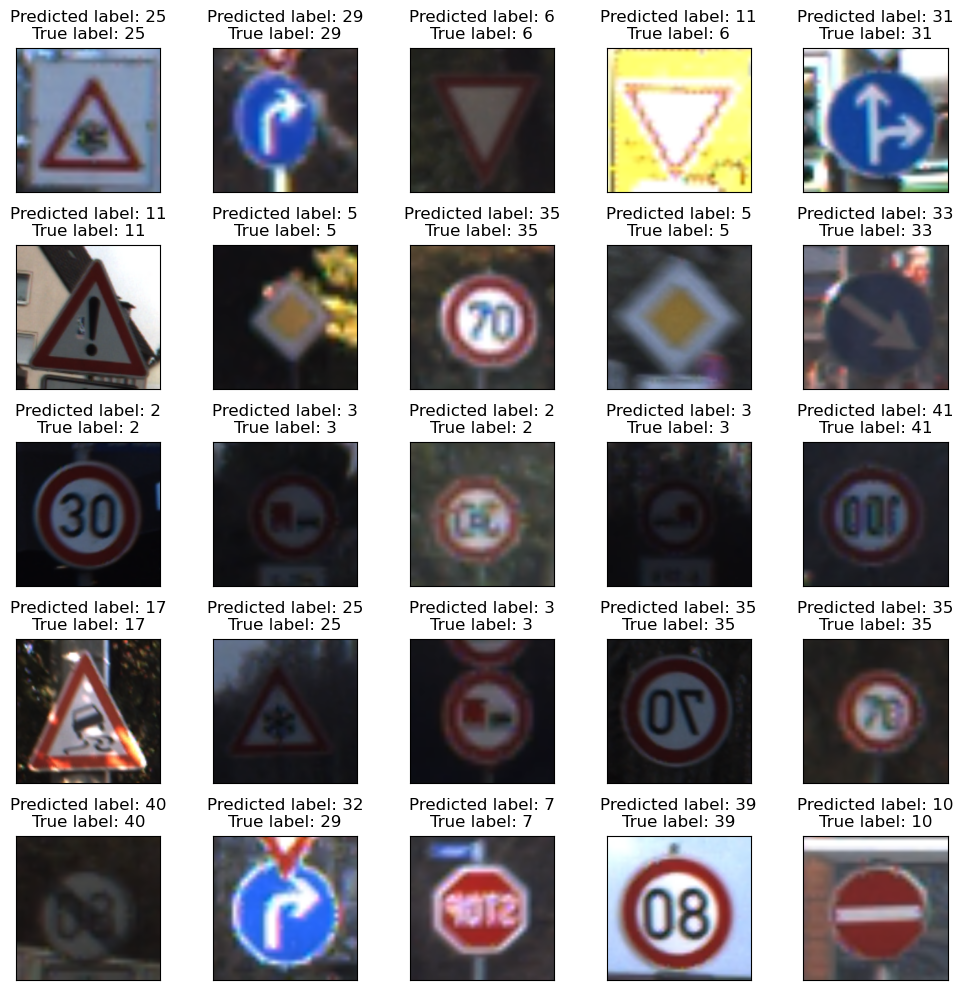

In [135]:
pred_labels, true_labels, test_loss, accuracy, images = evaluate_model(cnn_model, test_loader, 5)  

# Call the function to display 5*5 grid of sample images along with predicted and true labels
disp_images(images[:25], pred_labels[:25], true_labels[:25])

In [136]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           1       0.83      1.00      0.91        48
           2       0.90      0.93      0.91       442
           3       0.94      0.95      0.95       399
           4       0.75      0.99      0.85       252
           5       0.98      0.98      0.98       414
           6       0.98      0.98      0.98       436
           7       0.98      0.99      0.99       146
           8       1.00      0.88      0.93       138
           9       0.82      1.00      0.90        77
          10       1.00      1.00      1.00       219
          11       0.82      1.00      0.90       241
          12       0.93      0.67      0.78        39
          13       0.93      0.78      0.85       465
          14       0.91      0.60      0.72        72
          15       0.74      0.82      0.78        66
          16       1.00      0.95      0.98        85
          17       0.84      0.78      0.81       108
          18       1.00    

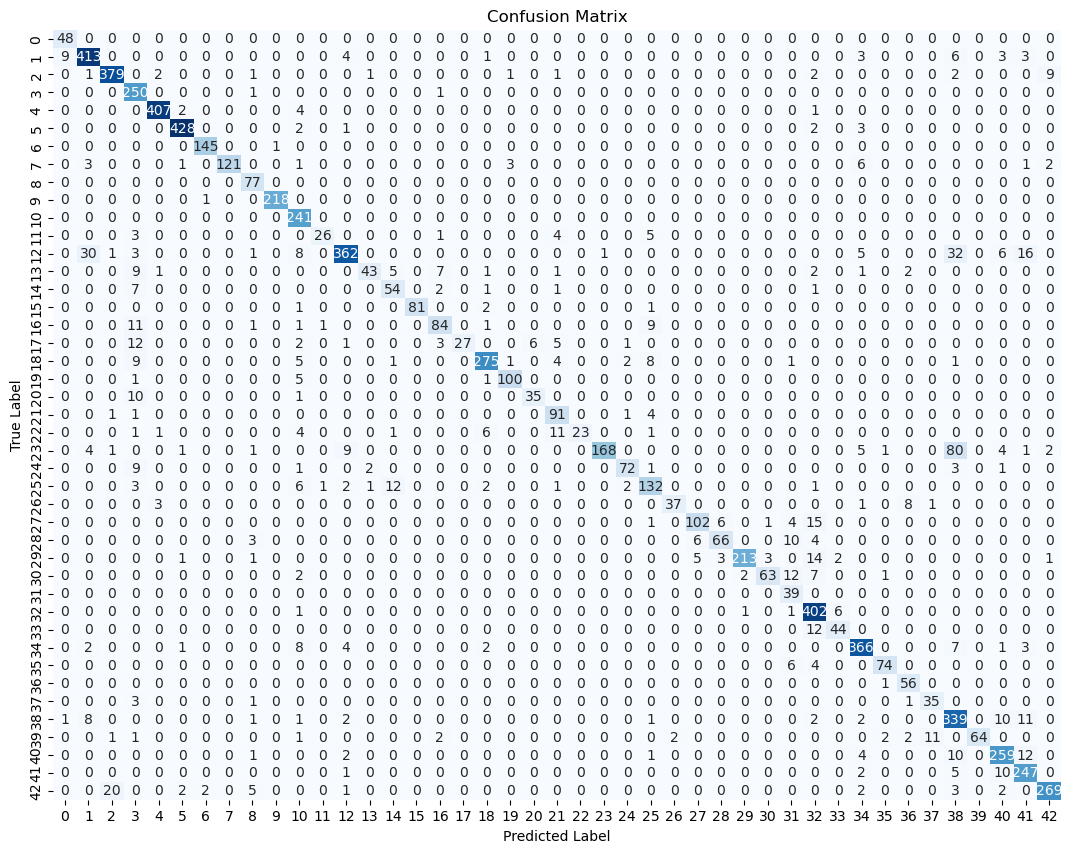

In [137]:
plot_confusion_matrix(true_labels, pred_labels)

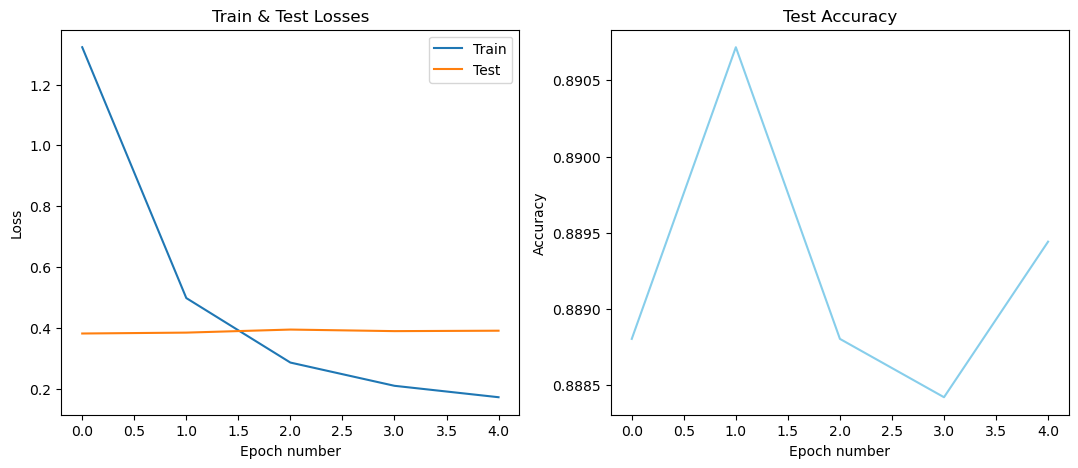

In [138]:
plot_loss_graphs(train_loss, test_loss, accuracy)

## Multilayer Perceptron Model

In [139]:
# Define the model
class MLP(nn.Module): 
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        for i in range(1, len(hidden_sizes)):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        x = self.flatten(x)
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.output_layer(x)
        return x


In [140]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = MLP(input_size=3 * 224 * 224, hidden_sizes=[256, 128], output_size=len(dataset.classes))

In [141]:
start_mlp = time.time()
mlp_model, train_loss = train_model(mlp_model, train_loader, 5)
end_mlp = time.time()

# Calculate time taken by MLP to train
time_mlp = end_mlp - start_mlp
print("MLP Training time:", time_mlp, "seconds")

# Save the trained mlp model
torch.save(mlp_model.state_dict(), 'mlp_model.pth')

Epoch 1/5 - Training Loss: 2.4239
Epoch 2/5 - Training Loss: 1.2179
Epoch 3/5 - Training Loss: 0.9659
Epoch 4/5 - Training Loss: 0.8654
Epoch 5/5 - Training Loss: 0.7889
MLP Training time: 747.6707789897919 seconds


Test Loss: 0.8109, Test Accuracy: 75.69%
Test Loss: 0.8080, Test Accuracy: 75.99%
Test Loss: 0.8070, Test Accuracy: 75.89%
Test Loss: 0.8077, Test Accuracy: 76.12%
Test Loss: 0.8066, Test Accuracy: 75.64%


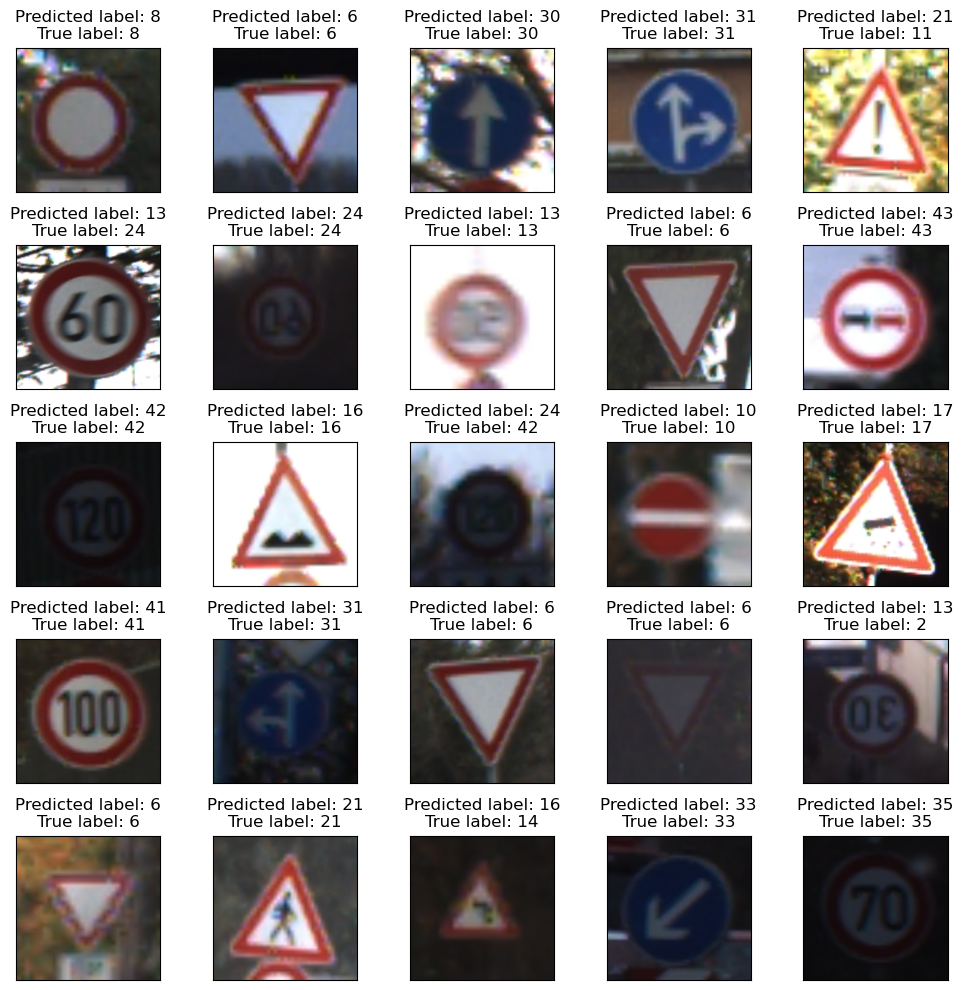

In [142]:
pred_labels, true_labels, test_loss, accuracy, images = evaluate_model(mlp_model, test_loader, 5) 

# Call the function to display 5*5 grid of sample images along with predicted and true labels
disp_images(images[:25], pred_labels[:25], true_labels[:25])

In [143]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           1       1.00      0.10      0.19        48
           2       0.66      0.35      0.45       442
           3       0.89      0.87      0.88       399
           4       0.85      0.88      0.87       252
           5       1.00      0.95      0.98       414
           6       0.98      0.97      0.97       436
           7       0.99      0.89      0.94       146
           8       0.94      0.70      0.80       138
           9       0.98      0.71      0.83        77
          10       0.99      0.98      0.99       219
          11       0.84      0.87      0.86       241
          12       0.58      0.38      0.46        39
          13       0.38      0.92      0.54       465
          14       0.40      0.22      0.29        72
          15       0.77      0.62      0.69        66
          16       0.87      0.89      0.88        85
          17       0.58      0.75      0.65       108
          18       0.55    

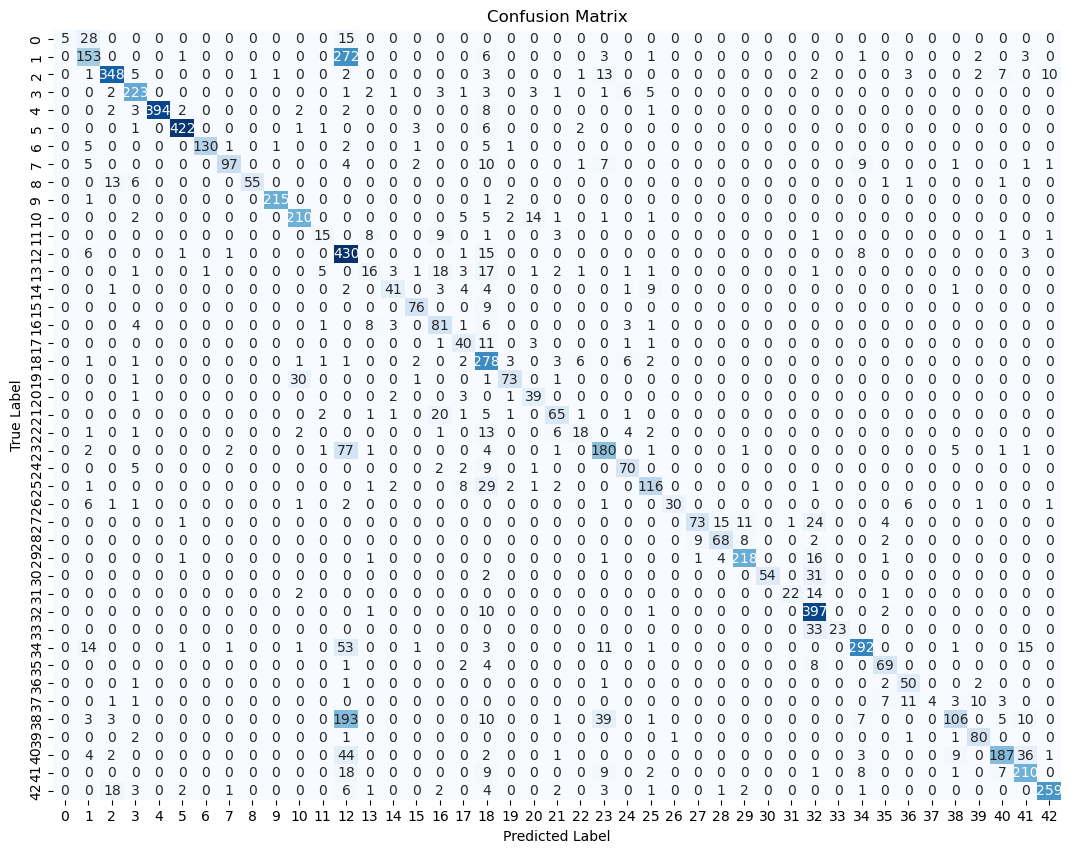

In [144]:
plot_confusion_matrix(true_labels, pred_labels)

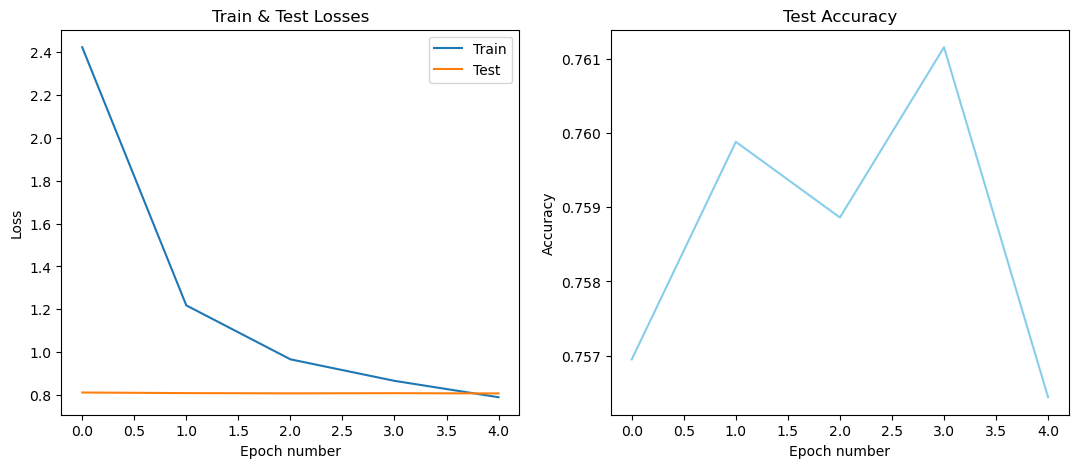

In [145]:
plot_loss_graphs(train_loss, test_loss, accuracy)